# Analysis fastReach 

## general prep

In [1]:

# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
# %load_ext rpy2.ipython # currently not needed
import glob

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
   


In [2]:
# set path
d = "C://Users/terfu/Desktop/2021-fastReach/analyses/Leonie_tests/"

## load functions

In [3]:
# plot with two cats
def plot_2_cats(data, x, y, hue, ylabel, xlabel,cats,palette):
    
    cats_0 = data[data[x]==cats[0]]
    cats_1 = data[data[x]==cats[1]]

    pairs = [(cats[0], cats[1])]

    ###  get p values for paired t test between two conditions

    pvalues = [
        stats.ttest_rel( cats_0[y], cats_1[y]).pvalue
        #stats.ranksums(cat_0[dv], cat_1[dv]).pvalue
    ]
    
    # Transform each p-value to "p=" in scientific notation
    formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]

    with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True

        #  show lines connecting single observations    
        sns.lineplot(data = data, x = x, y = y, hue = data.pID, legend = False, palette = sns.color_palette(['grey'], len(data.pID.unique())), linewidth = 0.5, linestyle = '--', alpha = 0.5,ci =None)
        

        #Show each observation with a scatterplot
        sns.stripplot(data = data,x = x, y = y, hue = None,size=10, dodge=True, alpha=.5, label=None, jitter = 0.04,palette= palette)

        # show boxplots
        #sns.boxplot(data = data,x = x, y = y,  palette= palette)

        # show line connecting menas
        sns.pointplot(
            data = data,x = x, y = y, dodge=.8 - .8 / 3,
            markers="d", scale=.75, ci =None)


        # Add annotations
        annotator = Annotator(ax, pairs = [(cats[0], cats[1])], data = data,x = x, y = y)
        annotator.configure(text_format="simple")
        annotator.set_pvalues(pvalues)
        annotator.annotate()

        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

        plt.show()

        fig.savefig('results/'+ title + '_' + ylabel + '_' + xlabel + '.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

In [4]:
# plot with three condition 

def plot_3_cats(data, x, y, hue, ylabel, xlabel,cats,palette,data_means):
    
    cats_0 = data[data[x]==cats[0]]
    cats_1 = data[data[x]==cats[1]]
    cats_2 = data[data[x]==cats[2]]

    pairs = [(cats[0], cats[1],cats[1])]

    ###  get p values for paired t test between two conditions

    #pvalues = [
     #   stats.ttest_rel( cats_0[y], cats_1[y],cats_2[y]).pvalue
        #stats.ranksums(cat_0[dv], cat_1[dv]).pvalue
    #]
    
    # Transform each p-value to "p=" in scientific notation
    #formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]

    with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True
         # show boxplots
        #sns.boxplot(data = data,x = x, y = y,  palette= palette)

        #  show lines connecting single observations    
        sns.lineplot(data = data_means, x = x, y = y, hue = hue, legend = False, palette = sns.color_palette(['grey'], len(data.pID.unique())), linewidth = 0.5, linestyle = '--', alpha = 0.5,ci =None)
        

        #Show each observation with a scatterplot
        sns.stripplot(data = data_means,x = x, y = y, hue = None,size=10, dodge=True, alpha=.5, label=None,palette= palette)

       

        # show line connecting menas
        sns.pointplot(
            data = data,x = x, y = y, dodge=.8 - .8 / 3,
            markers="d", scale=.75, ci =None)


        # Add annotations
        #annotator = Annotator(ax, pairs = [(cats[0], cats[1])], data = data,x = x, y = y)
        #annotator.configure(text_format="simple")
        #annotator.set_pvalues(pvalues)
        #annotator.annotate()

        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

        plt.show()

        fig.savefig('results/'+ title + '_' + ylabel + '_' + xlabel + '.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

In [5]:
# plot with three condition 

def plot_3_cats_hue(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,hue2):
    
    cats_0 = data[data[x]==cats[0]]
    cats_1 = data[data[x]==cats[1]]
    cats_2 = data[data[x]==cats[2]]

    pairs = [(cats[0], cats[1],cats[1])]

    ###  get p values for paired t test between two conditions

    #pvalues = [
     #   stats.ttest_rel( cats_0[y], cats_1[y],cats_2[y]).pvalue
        #stats.ranksums(cat_0[dv], cat_1[dv]).pvalue
    #]
    
    # Transform each p-value to "p=" in scientific notation
    #formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]

    with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True
         # show boxplots
        sns.boxplot(data = data,x = x, y = y, hue = hue2, palette= palette)

        #  show lines connecting single observations    
        sns.lineplot(data = data_means, x = x, y = y, hue = hue, legend = False, palette = sns.color_palette(['grey'], len(data.pID.unique())), linewidth = 0.5, linestyle = '--', alpha = 0.5,ci =None)
        

        #Show each observation with a scatterplot
        sns.stripplot(data = data_means,x = x, y = y, hue = None,size=10, dodge=True, alpha=.5, label=None,palette= palette)

       

        # show line connecting menas
        sns.pointplot(
            data = data,x = x, y = y, dodge=.8 - .8 / 3,
            markers="d", scale=.75, ci =None)


        # Add annotations
        #annotator = Annotator(ax, pairs = [(cats[0], cats[1])], data = data,x = x, y = y)
        #annotator.configure(text_format="simple")
        #annotator.set_pvalues(pvalues)
        #annotator.annotate()

        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

        plt.show()

        fig.savefig('results/'+ title + '_' + ylabel + '_' + xlabel + '.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

# 1. Intentional Binding
- input: 3 tabels for each pID: pID | stim_cond (basline vs. random vs. EEG)| temp_cond (200|350|500??) | IB_estimate

- think about defintion of IB_estimate
- linear-mixed-model mit  IB_estimate ~ stim_cond * temp_cond + (1|pID)
- liklyhood ratio test to check for significant influences
- if the case: post-hoc test = read up which ones
- Visualization: Boxpolts with 3 boxes (stim_conditions), or 9 boxes (both, x = temp_condition) --> depending on significance of temp_condition
- connect means, show points for participands
- maybe grey out basline (since not analyzed in the other data)

missing:
- make pretty
- add time as catgory
- add statistical test
- 


- 

In [3]:
# merge data
filenames = glob.glob(d + 'fake_data/ib_estimate' + "/*.csv")

data_list =[]
for filename in filenames:
    data = pd.read_csv(filename, index_col=None, header=0, sep = ";",decimal=",")
    data_list.append(data)

ib = pd.concat(data_list, axis=0, ignore_index=True)
ib.ib_estimate = pd.to_numeric(ib.ib_estimate)
ib[['stimulation_condition','temp_condition']] = ib[['stimulation_condition','temp_condition']].astype("category")


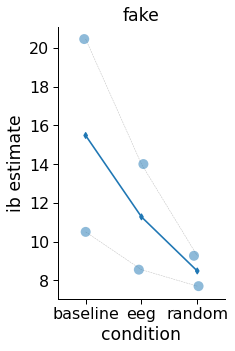

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
# with only stimulation condition
ib_means = ib.groupby(['pID','stimulation_condition'],as_index=False)['ib_estimate'].mean()

palette = sns.color_palette(palette=None, n_colors=1)
cats= ['baseline','random','EEG'] 
ylabel = 'ib estimate'
xlabel = 'condition'
title = 'fake'
data = ib
data_means = ib_means
y = "ib_estimate"
x = "stimulation_condition"
hue = "pID"


plot_3_cats(data, x, y, hue, ylabel, xlabel,cats,palette,data_means)

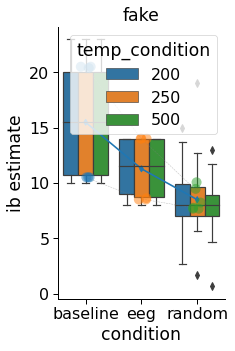

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
# with only stimulation condition + time contions
ib_means = ib.groupby(['pID','stimulation_condition','temp_condition'],as_index=False)['ib_estimate'].mean()

palette = sns.color_palette(palette=None, n_colors=3)
cats= ['baseline','random','EEG'] 
ylabel = 'ib estimate'
xlabel = 'condition'
title = 'fake'
data = ib
data_means = ib_means
y = "ib_estimate"
x = "stimulation_condition"
hue = "pID"
hue2 = 'temp_condition'



plot_3_cats_hue(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,hue2)

### linear mixed model

In [31]:
!pip install -q rpy2
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
R[write to console]: Warning:
R[write to console]:  Pakete 'lme4', 'lmerTest' werden gerade benutzt und deshalb nicht installiert

R[write to console]: Installiere Pakete nach 'C:/Users/terfu/AppData/Local/R/win-library/4.2'
(da 'lib' nicht spezifiziert)

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/emmeans_1.8.4-1.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2133259 bytes (2.0 MB)

R[write to console]: downloaded 2.0 MB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/geepack_1.3.9.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 899044 bytes (877 KB)

R[write to console]: downloaded 877 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/sjPlot_2.8.12.zip'

R[write to c

Paket 'emmeans' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'geepack' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'sjPlot' erfolgreich ausgepackt und MD5 Summen abgeglichen



Exception ignored from cffi callback <function _consolewrite_ex at 0x0000017DC0112CB0>:
Traceback (most recent call last):
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 25: invalid continuation byte


<rpy2.rinterface_lib.sexp.NULLType object at 0x0000017DC112B040> [RTYPES.NILSXP]

In [29]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [38]:
%%R -i ib
#
library("sjPlot")
#built models
full_model <-lmer(ib_estimate ~ stimulation_condition + temp_condition + (1|pID), data = ib ,REML = F)
tab_model(full_model,file = "C://Users/terfu/Desktop/2021-fastReach/analyses/Leonie_tests/a")
null_model_stim <-lmer(ib_estimate ~  temp_condition + (1|pID), data = ib ,REML = F)
null_model_temp<-lmer(ib_estimate ~ stimulation_condition + (1|pID), data = ib ,REML = F)


anova_stim <-anova(full_model,null_model_stim)[2, c("Chisq", "Df","Pr(>Chisq)")]
anova_temp <-anova(full_model,null_model_temp)[2, c("Chisq", "Df","Pr(>Chisq)")]

anova_stim 

c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "temp_condition". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


           Chisq Df Pr(>Chisq)    
full_model 90.83  2  < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [39]:
lmer(ib_estimate ~  temp_condition + (1|pID), data = ib ,REML = F)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2604966179.py, line 1)

[1] 20


# 2. Questionaire results
- items per block "„Während der Aufgabe hat es sich angefühlt, als hätte ich die Kontrolle über die Bewegungen.“
- input pid|first_block|control_random|control_EEG|expectation_fit|embodiment
- paired t-testsf
- box plots
- SD,M,effect size

@ Lukas? Significance test mit 5 values ist wirklich etwas shady, oder?

In [9]:
#propably makes sense to integrate all subjective data
# load  / merge qustionaire data

questionaire= pd.read_csv('fake_data/subjective_fastReach.csv', sep = ';')

### plot control

control_EEG vs. control_random: Custom statistical test, P_val:1.923e-01


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


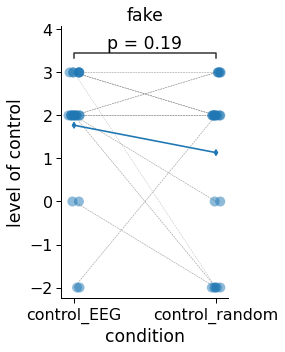

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
questionaire_long = questionaire.melt(id_vars= ['pID'],value_vars=['control_EEG','control_random'])

palette = sns.color_palette(palette=None, n_colors=1)
cats= ['control_random', 'control_EEG']
ylabel = 'level of control'
xlabel = 'condition'
title = 'fake'
data = questionaire_long
y = "value"
x = "variable"
hue = "pID"

plot_2_cats(data, x, y, hue, ylabel, xlabel,cats,palette)

#cohend(data,x,y, cats)

### numbers control

In [11]:
questionaire_long.groupby('variable')['value'].agg(["mean", "std"])


,mean,std
variable,,
control_EEG,1.772727,1.477830
control_random,1.136364,1.909761


### count expectation

In [12]:
questionaire['expectation_fit'].value_counts()

eeg       13
random     9
Name: expectation_fit, dtype: int64

### count embodiment

In [108]:
questionaire['embodiment'].value_counts()

nein    11
ja      11
Name: embodiment, dtype: int64

# 3. Content Analysis
- built to world clouds for each block
- define stopwords
- maybe check sentiment analysis -> pareid t-test?


In [13]:
interview_random_text = questionaire['interview_random'].to_json()

interview_eeg_text = questionaire['interview_EEG'].to_json()

stopwords = STOPWORDS # extend by domaine specific words if necessary



In [14]:
wc_formate = WordCloud(background_color='black', max_words=500, width=3000,
                    height=1500, stopwords=stopwords, min_font_size=2,
                    contour_width=3, contour_color='black')

wc_formate.generate(interview_random_text)
wc_formate.to_file((d+"results/wordcloud_random.png"))

wc_formate.generate(interview_eeg_text)
wc_formate.to_file((d+"results/wordcloud_eeg.png"))


# 4. Sentiment Analysis

In [15]:
# for whole text

analyzer=SentimentIntensityAnalyzer()  

analyzer.polarity_scores(interview_random_text)
analyzer.polarity_scores(interview_eeg_text)



{'neg': 0.104, 'neu': 0.735, 'pos': 0.161, 'compound': 0.9879}